In [1]:
import urllib.request
import zipfile

url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
filename = "jena_climate_2009_2016.csv.zip"
urllib.request.urlretrieve(url, filename)
with zipfile.ZipFile("jena_climate_2009_2016.csv.zip","r") as zip_ref:
    zip_ref.extractall()

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
   data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

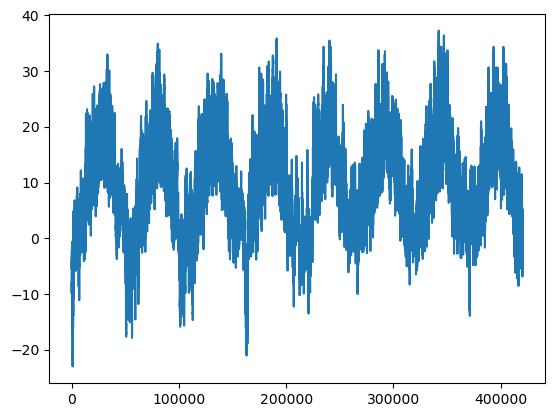

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

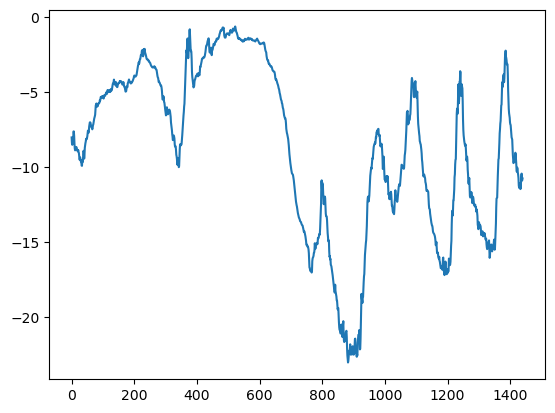

In [5]:
plt.plot(range(1440), temperature[:1440]) 

In [6]:
from tensorflow import keras
import numpy as np

total = len(temperature)
train = total // 2
val = (total - train) // 2
test = total - train - val

delay = 1 # pasos de tiempo para retroceder (predecir temperatura de mañana con datos de hoy)
sequence_length = 120 
sampling_rate = 1 # cada cuanto vas a tomar datos (en este caso cada muestra, o sea cada 10 min)
batch_size = 10

print("Totales =", total)
print("Entrenamiento =", train)
print("Validacion =", val)
print("Prueba =", test)

Totales = 420451
Entrenamiento = 210225
Validacion = 105113
Prueba = 105113


In [7]:
# Conjuntos de secuencias
# entrenamiento
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train)
# validacion
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train,
    end_index=train + val)
# test
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=val+train,
    end_index=None)

# Conv 1D

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Lambda, Convolution1D
from tensorflow.keras.utils import to_categorical

In [9]:
def slice(x, slice_length):
         return x[:, -slice_length:, :]

ks = 5
look_ahead =  delay

modeldil = Sequential()

modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1,
                           batch_input_shape=(None, None, 1)))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))

modeldil.add(Dense(1))
modeldil.add(Lambda(slice, arguments={'slice_length':look_ahead}))

modeldil.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          5152      
                                                                 
 dense (Dense)               (None, None, 1)           33        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 15681 (61.25 KB)
Trainable params: 15681 (

In [10]:
modeldil.compile(optimizer='adam',loss='mean_squared_error')

histdil = modeldil.fit(train_dataset,
                    epochs=20,#tenia 200
                    batch_size=batch_size,
                    validation_data=val_dataset, verbose=0)

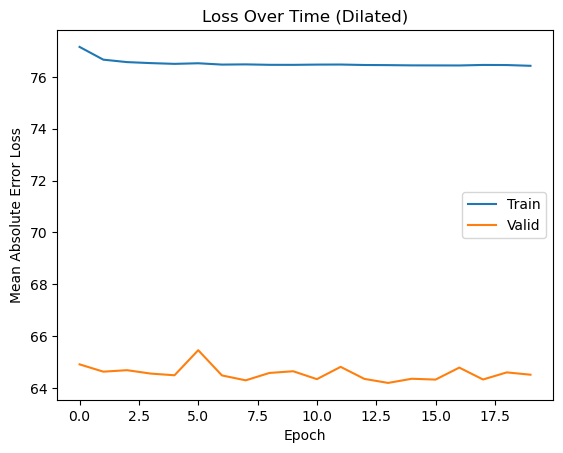

In [11]:
plt.plot(histdil.history['loss'])
plt.plot(histdil.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time (Dilated)')
plt.legend(['Train','Valid'])

10500/10500 [==============================] - 36s 3ms/step


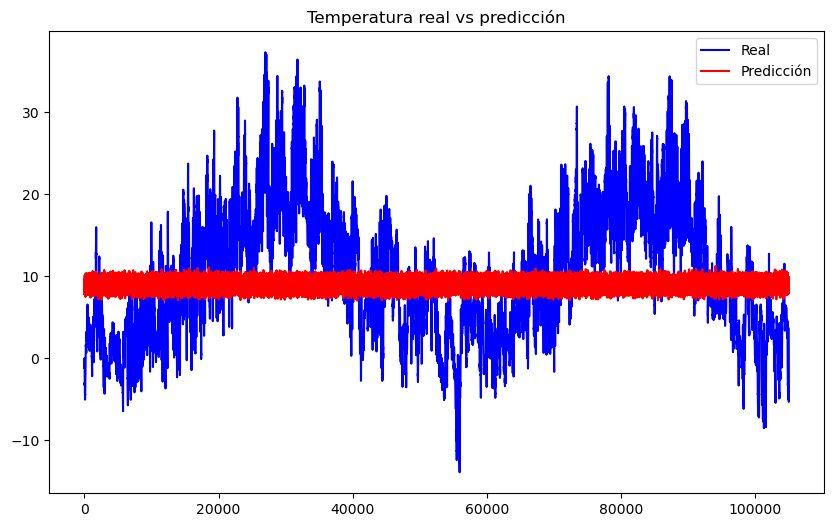

In [12]:
predictions = modeldil.predict(test_dataset)
predictions = predictions.flatten()
real_data = temperature[val+train:]
real_data = real_data[:len(predictions)]

plt.figure(figsize=(10,6))
plt.plot(real_data, color='blue', label='Real')
plt.plot(predictions, color='red', label='Predicción')
plt.title('Temperatura real vs predicción')
plt.legend()
plt.show()